In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import argparse
import time
import msgpack
from enum import Enum, auto

import numpy as np

from voxmap import create_voxmap, create_voxgrid
# from planning_utils import a_star, heuristic, create_grid
from planning_utils import create_grid
from planning_utils3D import a_star3D2, heuristic3D, create_grid25, heuristic_man
from udacidrone import Drone
from udacidrone.connection import MavlinkConnection
from udacidrone.messaging import MsgID
from udacidrone.frame_utils import global_to_local

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

In [6]:
class States(Enum):
    MANUAL = auto()
    ARMING = auto()
    TAKEOFF = auto()
    WAYPOINT = auto()
    LANDING = auto()
    DISARMING = auto()
    PLANNING = auto()

In [7]:
class MotionPlanning(Drone):

    def __init__(self, connection, global_goal=None, local_goal=None, grid_goal=None, waypoints=[], landing_altitude=0):
        super().__init__(connection)

        self.target_position = np.array([0.0, 0.0, 0.0])
        self.waypoints = []
        # To start an instance with pre-calculated WPs
        if waypoints is not None and len(waypoints) > 0:
            self.waypoints = waypoints        
        self.in_mission = True
        self.check_state = {}
        
        self.landing_altitude = 0.0
        if landing_altitude > 0:
            self.landing_altitude = landing_altitude
        self.takeoff_counter = 0
        self.timeout = connection._timeout
        self.is_timeout = False

        self.global_goal = global_goal
        self.local_goal = local_goal
        self.grid_goal = grid_goal
        # initial state
        self.flight_state = States.MANUAL

        # register all your callbacks here
        self.register_callback(MsgID.LOCAL_POSITION, self.local_position_callback)
        self.register_callback(MsgID.LOCAL_VELOCITY, self.velocity_callback)
        self.register_callback(MsgID.STATE, self.state_callback)

    def local_position_callback(self):
        if self.flight_state == States.TAKEOFF:
            if -1.0 * self.local_position[2] > 0.95 * self.target_position[2]:
                self.waypoint_transition()
        elif self.flight_state == States.WAYPOINT:
            local_pos = self.local_position[:3]
            local_pos[2] = local_pos[2] * -1.0
            dist_to_wp = np.linalg.norm(self.target_position[:3] - local_pos)
            if dist_to_wp < 3.0:
                if len(self.waypoints) > 0:
                    self.waypoint_transition()
                elif (dist_to_wp < 1.0):
                    if np.linalg.norm(self.local_velocity[0:2]) < 1.0:
                        self.landing_transition()

    def velocity_callback(self):
        if self.flight_state == States.LANDING:
            if self.global_position[2] - self.landing_altitude < 0.1:
                self.disarming_transition()

    def state_callback(self):
        if self.in_mission:
            if self.flight_state == States.MANUAL:
                self.arming_transition()
            elif self.flight_state == States.ARMING:
                if self.armed:
                    self.plan_path()
            elif self.flight_state == States.PLANNING:
                self.takeoff_transition()
            elif self.flight_state == States.DISARMING:
                if ~self.armed & ~self.guided:
                    self.manual_transition()

    def arming_transition(self):
        self.flight_state = States.ARMING
        print("arming transition")
        self.arm()
        self.take_control()

    def takeoff_transition(self):
        self.flight_state = States.TAKEOFF
        print("takeoff transition")
        self.takeoff(self.target_position[2])

    def waypoint_transition(self):
        self.flight_state = States.WAYPOINT
        print("waypoint transition")
        self.target_position = self.waypoints.pop(0)
        print('target position', self.target_position)
        self.cmd_position(self.target_position[0], self.target_position[1], self.target_position[2], self.target_position[3])

    def landing_transition(self):
        self.flight_state = States.LANDING
        print("landing transition")
        self.land()

    def disarming_transition(self):
        self.flight_state = States.DISARMING
        print("disarm transition")
        self.disarm()
        self.release_control()

    def manual_transition(self):
        self.flight_state = States.MANUAL
        print("manual transition")
        self.stop()
        self.in_mission = False

    def send_waypoints(self):
        print("Sending waypoints to simulator ...")
        data = msgpack.dumps(self.waypoints)
        self.connection._master.write(data)

    def plan_path(self):
        pass

    def start(self):
        self.start_log("Logs", "NavLog.txt")

        print("starting connection")
        self.connection.start()

        # Only required if they do threaded
        # while self.in_mission:
        #    pass

        self.stop_log()
        
    def local_to_grid(self, north_offset, east_offset):
        if len(self.local_goal) == 2:
            ng, eg = self.local_goal
        elif len(self.local_goal) == 3:
            ng, eg, ag = self.local_goal
        self.grid_goal = grid_goal = (int(np.rint(ng - north_offset)), int(np.rint(eg - east_offset)))
    
    def global_to_grid(self, north_offset, east_offset):
        self.local_goal = global_to_local(self.global_goal, global_home=self.global_home)
        self.local_to_grid(north_offset, east_offset)
    
    def place_goal_in_grid(self, grid_shape):
        grid_goal = self.grid_goal
        if grid_goal[0] > grid_shape[0] - 2:
            grid_goal = (grid_shape[0] - 2, grid_goal[1])
        elif grid_goal[0] < 1:
            grid_goal = (1, grid_goal[1])            
        if grid_goal[1] > grid_shape[1] - 2:
            grid_goal = (grid_goal[0], grid_shape[1] - 2)
        elif grid_goal[1] < 1:
            grid_goal = (grid_goal[0], 1)  
        self.grid_goal = grid_goal        

In [8]:
def main(drn=None, global_goal=None, local_goal=None, grid_goal=None):
    print("main")
    #parser = argparse.ArgumentParser()
    #parser.add_argument('--port', type=int, default=5760, help='Port number')
    #parser.add_argument('--host', type=str, default='127.0.0.1', help="host address, i.e. '127.0.0.1'")
    #args = parser.parse_args()
    timeout = 60
    try_count = 3
    try_i = 0
    is_timeout = True
    waypoints = None
    landing_altitude = 0
    t0 = time.time()
    
    # If there is a timeout with a drone instance,
    # the instance terminates itself
    # main will transfer the WPs to a new instance    
    while (is_timeout and try_i < try_count):
        conn = MavlinkConnection('tcp:{0}:{1}'.format('127.0.0.1', 5760), timeout=timeout)
        drone = MotionPlanning(conn,
                               global_goal=global_goal,
                               local_goal=local_goal,
                               grid_goal=grid_goal,
                              waypoints=waypoints,
                              landing_altitude=landing_altitude)
        time.sleep(1)
        drone.start()
        try_i += 1
        print("%s. is_timeout:%s, state:%s, connected:%s, in_mission:%s, armed:%s, t:%s" %(
        try_i, drone.is_timeout, drone.flight_state, drone.connected, drone.in_mission, drone.armed, time.time() - t0))
        is_timeout = drone.is_timeout
        waypoints = drone.waypoints
        landing_altitude = drone.landing_altitude

In [9]:
def plot(grid, start_ne, goal_ne, path=None):
    plt.figure(figsize=(24, 12))
    plt.imshow(grid, cmap='Greys', origin='lower')
    
    # For the purposes of the visual the east coordinate lay along
    # the x-axis and the north coordinates long the y-axis.
    plt.plot(start_ne[1], start_ne[0], 'gx', markersize=5, markeredgewidth=5)
    plt.plot(goal_ne[1], goal_ne[0], 'rx', markersize=5, markeredgewidth=5)

    if path is not None:
        pp = np.array(path)
        #pp = np.array(parr)
        plt.plot(pp[:, 1], pp[:, 0], 'g')

    plt.xlabel('EAST')
    plt.ylabel('NORTH')
    plt.show()    

In [10]:
def plot3D(voxmap, vox_start, vox_goal, path=None):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.set_xlim(voxmap.shape[0], 0)
    ax.set_ylim(0, voxmap.shape[1])
    ax.set_zlim(0, voxmap.shape[2])

    if path is not None:
        pp = np.array(path)
        ax.plot(pp[:, 1], pp[:, 0], pp[:, 2], 'g')

    ax.plot([vox_start[1]], [vox_start[0]], [vox_start[2]], 'gx',markersize=10,markeredgewidth=3)
    ax.plot([vox_goal[1]], [vox_goal[0]], [vox_goal[2]], 'rx',markersize=10,markeredgewidth=3)

    plt.xlabel('North')
    plt.ylabel('East')

    plt.show()

In [11]:
def point(p):
    return np.array([p[0], p[1], 1.]).reshape(1, -1)

def collinearity_check(p1, p2, p3, epsilon=1e-6):   
    m = np.concatenate((p1, p2, p3), 0)
    det = np.linalg.det(m)
    return abs(det) < epsilon

def prune_path(path, voxel_size=None, max_p=50):
    max_p = max_p // voxel_size
    pruned_path = [p for p in path]
    i = 0
    ri = 0
    while i < len(pruned_path) - 2:
        p1 = point(pruned_path[i])
        p2 = point(pruned_path[i+1])
        p3 = point(pruned_path[i+2])
        if collinearity_check(p1,p2,p3) and ri < max_p:
            pruned_path.remove(pruned_path[i+1])
            ri += 1
        else:
            i += 1
            ri = 0
    return pruned_path

In [12]:
def plan_path(self):
    self.flight_state = States.PLANNING
    t0 = time.time()
    
    print("Searching for a path ...")
    
    TARGET_ALTITUDE = 5
    SAFETY_DISTANCE = 5
    VOXEL_SIZE = 5
    MAX_ALTITUDE = 250

    # Number of nodes to prune at max
    max_prune = 20

    self.target_position[2] = TARGET_ALTITUDE

    # If WPs calculated previously, send them directly
    # Work around for timeout
    if self.waypoints is not None and len(self.waypoints) > 0:
        time.sleep(2)
        print("waypoints:")
        print(self.waypoints)
        print(self.flight_state, self.in_mission, self.connected)
        self.send_waypoints()
        return    
    
    np.set_printoptions(precision=3)
    print('global home {0}, position {1}, local position {2}'.format(
        self.global_home, self.global_position, self.local_position))

    # Read in obstacle map
    data = np.loadtxt('colliders.csv', delimiter=',', dtype='Float64', skiprows=2)
    
    # TODO CHECK if all of them are used TODO
    # Define a grid for a particular altitude and safety margin around obstacles
    grid, north_offset, east_offset = create_grid(data, TARGET_ALTITUDE, SAFETY_DISTANCE)
    grid25, _,_ = create_grid25(data, SAFETY_DISTANCE)
    voxmap, north_offvox, east_offvox = create_voxmap(data, safety_distance=SAFETY_DISTANCE, max_altitude=MAX_ALTITUDE, voxel_size=VOXEL_SIZE)
    voxfull, north_offvox, east_offvox = create_voxmap(data, safety_distance=SAFETY_DISTANCE, max_altitude=MAX_ALTITUDE, voxel_size=1)
    
    grid_shape = grid.shape
    grid25_shape = grid25.shape
    vox_shape = voxmap.shape
    print("Grid shape = {0}, Grid2.5 shape = {1}, vox shape = {2}".format(
           grid_shape, grid25_shape, vox_shape))
    print("North offset = {0}, east offset = {1}, grid shape = {2}".format(north_offset, east_offset, grid.shape))
    print("North offvox = {0}, east offvox = {1}, vox shape = {2}".format(north_offvox, east_offvox, voxmap.shape))

    # Define starting point on the grid (this is just grid center)
    with open('colliders.csv') as f:
        first_line = f.readline().strip()
    latlon = first_line.split(',')
    lon0 = float(latlon[0].strip().split(' ')[1])
    lat0 = float(latlon[1].strip().split(' ')[1])      

    # TODO: convert start position to current position rather than map center
    # TODO: set home position to (lon0, lat0, 0)    
    self.set_home_position(lat0, lon0, 0)

    # TODO: retrieve current global position
    # TODO: convert to current local position using global_to_local()
    local_pos = global_to_local(self.global_position, global_home=self.global_home)
    north, east, att = local_pos

    grid_start = (int(np.rint(north - north_offset)), int(np.rint(east - east_offset)), int(np.rint(self.global_position[2])) + TARGET_ALTITUDE)
    vox_start = (grid_start[0] // VOXEL_SIZE,
             grid_start[1] // VOXEL_SIZE,
             grid_start[2] // VOXEL_SIZE)
    print("Grid Start: ",grid_start, "Vox Start: ", vox_start)

    if self.global_goal is not None:
        if len(self.global_goal) == 2:
            self.global_goal = (self.global_goal[0], self.global_goal[1], TARGET_ALTITUDE)
        self.global_to_grid(north_offset, east_offset)
    elif self.local_goal is not None:
        self.local_to_grid(north_offset, east_offset)    

    # If goal location is in an obstacle, goal is above it
    if self.grid_goal is not None:
        self.place_goal_in_grid(grid_shape)
        grid_goal = tuple(map(int, self.grid_goal))
        print("Goal is set to {0} with the parameter".format(grid_goal))
        goal_north, goal_east = grid_goal[:2]
        
    else:
        # randomly select a goal    
        dist_idx = 100.0

        change = np.random.rand(3)
        change[1:2] -= 0.5
        # TODO LOOK FOR THE VALUE OF CHANGE!!!
        print("change", change)
        goal = (self.global_home[0] + change[0] / dist_idx,
                self.global_home[1] + change[1] / (dist_idx),
                self.global_home[2] + change[2] * float(MAX_ALTITUDE))
        print("Goal Global: ", goal)
        local_goal = global_to_local(goal, global_home=self.global_home)
        print("Goal Local: ", local_goal)
        ng, eg, ag = local_goal

        goal_north = int(np.rint(ng - north_offset))
        goal_east = int(np.rint(eg - east_offset))

    if goal_north < 1:
        goal_north = 1
    elif goal_north > grid_shape[0] - 2:
        goal_north = grid_shape[0] - 2
    if goal_east < 1:
        goal_east = 1
    elif goal_east > grid_shape[1] - 2:
        goal_east = grid_shape[1] - 2
                
    goal_alt= int(np.rint(grid25[goal_north, goal_east] + SAFETY_DISTANCE))
    grid_goal = (goal_north, goal_east, goal_alt)
    self.landing_altitude = grid25[goal_north, goal_east]

    vox_goal = (grid_goal[0] // VOXEL_SIZE,
                 grid_goal[1] // VOXEL_SIZE,
                 grid_goal[2] // VOXEL_SIZE)

    while voxmap[vox_goal[0], vox_goal[1], vox_goal[2]]:
        vox_goal = (vox_goal[0], vox_goal[1], vox_goal[2]+1)
        grid_goal = (grid_goal[0], grid_goal[1], grid_goal[2] + VOXEL_SIZE)

    if vox_goal[0] >= vox_shape[0]:
        vox_goal = (vox_shape[0] - 1, vox_goal[1], vox_goal[2])
    elif vox_goal[0] < 1:
        vox_goal = (1, vox_goal[1], vox_goal[2])
    if vox_goal[1] >= vox_shape[1]:
        vox_goal = (grid_goal[0], vox_shape[1] - 1, vox_goal[2])
    elif vox_goal[1] < 1:
        vox_goal = (vox_goal[0], 1, vox_goal[2])

    print('Grid Start and Goal: ', grid_start, grid_goal)
    print('Vox Start and Goal: ', vox_start, vox_goal)
    # plot(grid, grid_start, grid_goal)

    # Run A* to find a path from start to goal
    # TODO: add diagonal motions with a cost of sqrt(2) to your A* implementation
    # or move to a different search space such as a graph (not done here)
    vox_path, cost = a_star3D2(voxmap, heuristic3D, vox_start, vox_goal)
    l_path = len(vox_path)
    print("Path length:", l_path," cost:", cost)
    
    path = [(p[0] * VOXEL_SIZE, p[1] * VOXEL_SIZE,p[2] * VOXEL_SIZE) for p in vox_path]    
    p1 = path[1]
    pn_1 = path[len(path) - 2]
    
    print("PATH START: grid_start:", grid_start, " p1:", p1)
    path_start, cost_start = a_star3D2(voxfull, heuristic3D, grid_start, p1, info=False)
    print("PATH GOAL: grid_goal:", grid_goal, " p1:", pn_1)
    path_goal, cost_goal = a_star3D2(voxfull, heuristic3D, grid_goal, pn_1, info=False)
    
    path = path_start + path[1:len(path) - 2] + path_goal
    cost = cost + cost_start + cost_goal

    #if VOXEL_SIZE == 1:
    #    plot(grid, grid_start, grid_goal, path=path)
    #plot3D(voxmap, vox_start, vox_goal, path=path)
    
    # TODO: prune path to minimize number of waypoints
    # TODO (if you're feeling ambitious): Try a different approach altogether!    
    pruned_path = prune_path(path, VOXEL_SIZE, max_prune)
    print("Pruned Path length: ", len(pruned_path))
    
    plot(grid, grid_start, grid_goal, path=pruned_path)
    plot3D(voxmap, vox_start, vox_goal, path=vox_path)
        
    #print("A* path:")
    #for p in path:
    #    print(p, voxmap[p[0], p[1], p[2]])
        
    #print("Pruned_path:")
    #for p in pruned_path:
    #    print(p)
    #    print(p, p.cost, p.delta, (p.delta[0] + north_offset, p.delta[1] + east_offset, TARGET_ALTITUDE, 0))

    # Convert path to waypoints
    waypoints = [[p[0] + north_offset, p[1] + east_offset, p[2], 0] for p in pruned_path]
    
    # Set self.waypoints
    self.waypoints = waypoints
    # TODO: send waypoints to sim (this is just for visualization of waypoints)
    t_int = time.time() - t0
    
    # If timeout, don't send WPs 
    # End this instance, main will start a new instance
    if t_int < self.timeout:
        print("no timeout, continue")
        self.send_waypoints()
    else:
        print("timeout, send wp to a new drone instance")
        self.is_timeout = True
        self.disarming_transition()
        self.manual_transition()
MotionPlanning.plan_path = plan_path


main
Logs/TLog.txt
Logs/NavLog.txt
starting connection
arming transition
Searching for a path ...
global home [-122.397   37.792    0.   ], position [-1.224e+02  3.779e+01  6.500e-02], local position [-0.021  0.002 -0.065]
Grid shape = (921, 921), Grid2.5 shape = (921, 921), vox shape = (184, 184, 50)
North offset = -316, east offset = -445, grid shape = (921, 921)
North offvox = -316, east offvox = -445, vox shape = (184, 184, 50)
Grid Start:  (316, 445, 5) Vox Start:  (63, 89, 1)
Goal is set to (600, 200, 100) with the parameter
Grid Start and Goal:  (316, 445, 5) (600, 200, 183)
Vox Start and Goal:  (63, 89, 1) (120, 40, 36)
#Nodes:1024, #Actions:25063, Cost:35.71, Currenct Node:(96, 56, 20), Time:1.78
#Nodes:2048, #Actions:50471, Cost:10.02, Currenct Node:(66, 82, 6), Time:3.64
#Nodes:4096, #Actions:101946, Cost:73.94, Currenct Node:(110, 52, 32), Time:8.83
found a midpoint
#Nodes:5398, #Actions:134795, Cost:84.28, Currenct Node:(115, 45, 36), Time:11.13
found mid
Path length: 62  

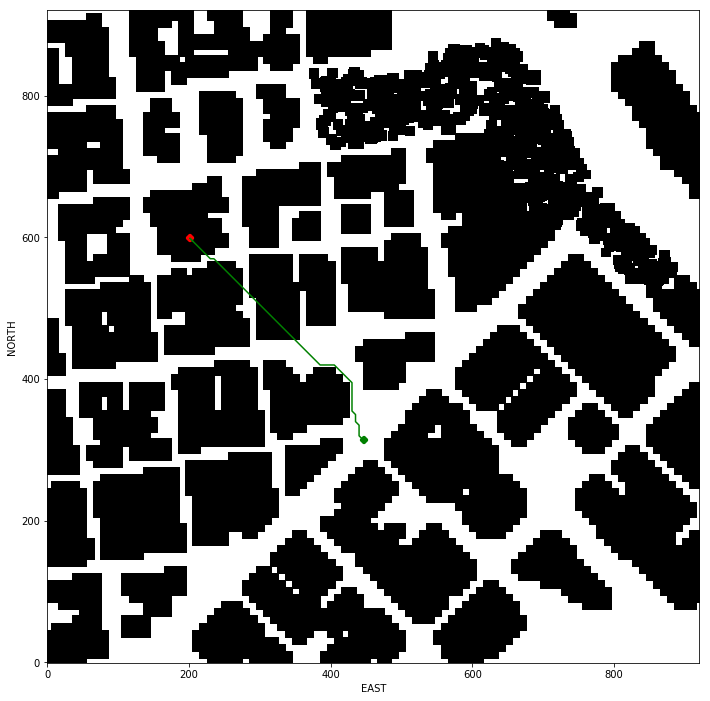

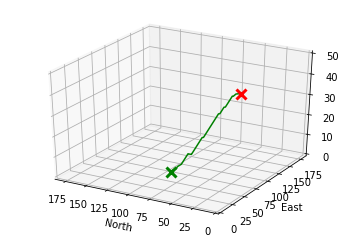

no timeout, continue
Sending waypoints to simulator ...
takeoff transition
waypoint transition
target position [0, 0, 5, 0]
waypoint transition
target position [0, -1, 6, 0]
waypoint transition
target position [4, -5, 10, 0]
waypoint transition
target position [19, -5, 10, 0]
waypoint transition
target position [24, -10, 10, 0]
waypoint transition
target position [34, -10, 10, 0]
waypoint transition
target position [39, -15, 15, 0]
waypoint transition
target position [64, -15, 15, 0]
waypoint transition
target position [79, -15, 15, 0]
waypoint transition
target position [104, -40, 40, 0]
waypoint transition
target position [104, -60, 40, 0]
waypoint transition
target position [129, -85, 65, 0]
waypoint transition
target position [154, -110, 85, 0]
waypoint transition
target position [179, -135, 110, 0]
waypoint transition
target position [204, -160, 135, 0]
waypoint transition
target position [229, -185, 150, 0]
waypoint transition
target position [254, -210, 175, 0]
waypoint transiti

In [13]:
# Top of the next building
main(grid_goal=(600,200,100))

main
Logs/TLog.txt
Logs/NavLog.txt
starting connection
arming transition
Searching for a path ...
global home [-122.397   37.792    0.   ], position [-122.4     37.795  173.18 ], local position [ 279.072 -239.96  -173.181]
Grid shape = (921, 921), Grid2.5 shape = (921, 921), vox shape = (184, 184, 50)
North offset = -316, east offset = -445, grid shape = (921, 921)
North offvox = -316, east offvox = -445, vox shape = (184, 184, 50)
Grid Start:  (593, 206, 178) Vox Start:  (118, 41, 35)
Goal is set to (320, 545, 5) with the parameter
Grid Start and Goal:  (593, 206, 178) (320, 545, 5)
Vox Start and Goal:  (118, 41, 35) (64, 109, 1)
#Nodes:1024, #Actions:23719, Cost:60.56, Currenct Node:(87, 83, 19), Time:1.72
#Nodes:2048, #Actions:49470, Cost:77.04, Currenct Node:(98, 64, 25), Time:3.60
#Nodes:4096, #Actions:101083, Cost:71.27, Currenct Node:(90, 69, 33), Time:8.93
#Nodes:8192, #Actions:203503, Cost:15.76, Currenct Node:(112, 53, 33), Time:17.58
found a midpoint
#Nodes:11041, #Actions:2

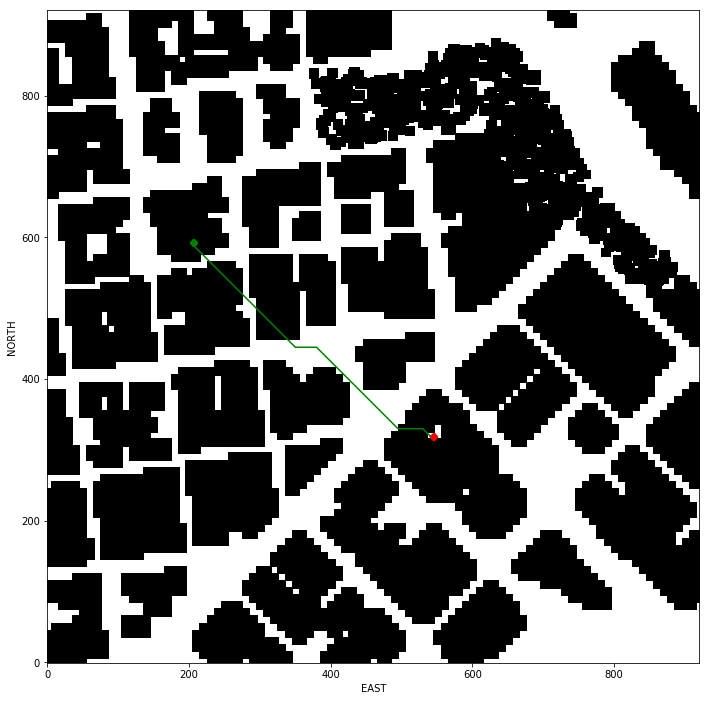

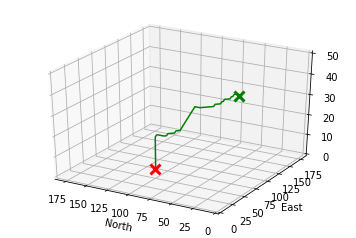

no timeout, continue
Sending waypoints to simulator ...
takeoff transition
waypoint transition
target position [277, -239, 178, 0]
waypoint transition
target position [276, -238, 179, 0]
waypoint transition
target position [273, -238, 179, 0]
waypoint transition
target position [272, -237, 180, 0]
waypoint transition
target position [270, -236, 180, 0]
waypoint transition
target position [254, -220, 180, 0]
waypoint transition
target position [229, -195, 170, 0]
waypoint transition
target position [199, -165, 160, 0]
waypoint transition
target position [174, -140, 155, 0]
waypoint transition
target position [149, -115, 155, 0]
waypoint transition
target position [129, -95, 155, 0]
waypoint transition
target position [129, -70, 155, 0]
waypoint transition
target position [129, -65, 155, 0]
waypoint transition
target position [104, -40, 130, 0]
waypoint transition
target position [79, -15, 105, 0]
waypoint transition
target position [54, 10, 95, 0]
waypoint transition
target position [29

In [14]:
# To the hole
main(grid_goal=(320, 545, 5))

main
Logs/TLog.txt
Logs/NavLog.txt
starting connection
arming transition
Searching for a path ...
global home [-122.397   37.792    0.   ], position [-1.224e+02  3.779e+01 -3.000e-02], local position [3.868e+00 9.516e+01 3.093e-02]
Grid shape = (921, 921), Grid2.5 shape = (921, 921), vox shape = (184, 184, 50)
North offset = -316, east offset = -445, grid shape = (921, 921)
North offvox = -316, east offvox = -445, vox shape = (184, 184, 50)
Grid Start:  (320, 539, 5) Vox Start:  (64, 107, 1)
Goal is set to (447, 900, 5) with the parameter
Grid Start and Goal:  (320, 539, 5) (447, 900, 5)
Vox Start and Goal:  (64, 107, 1) (89, 180, 1)
#Nodes:1024, #Actions:21997, Cost:6.41, Currenct Node:(83, 180, 0), Time:2.58
#Nodes:2048, #Actions:45678, Cost:54.15, Currenct Node:(73, 142, 15), Time:4.99
#Nodes:4096, #Actions:96071, Cost:43.76, Currenct Node:(76, 129, 11), Time:8.41
#Nodes:8192, #Actions:196240, Cost:61.76, Currenct Node:(86, 142, 8), Time:16.31
found a midpoint
#Nodes:13270, #Actions

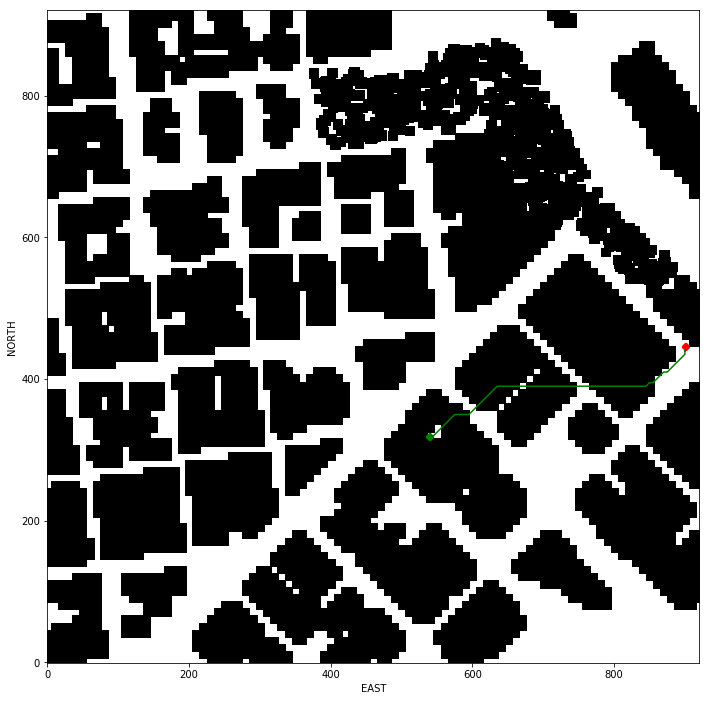

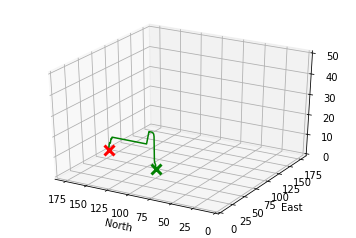

no timeout, continue
Sending waypoints to simulator ...
takeoff transition
waypoint transition
target position [4, 94, 5, 0]
waypoint transition
target position [4, 95, 10, 0]
waypoint transition
target position [4, 100, 20, 0]
waypoint transition
target position [9, 105, 45, 0]
waypoint transition
target position [9, 105, 70, 0]
waypoint transition
target position [19, 115, 90, 0]
waypoint transition
target position [34, 130, 90, 0]
waypoint transition
target position [34, 150, 90, 0]
waypoint transition
target position [59, 175, 65, 0]
waypoint transition
target position [74, 190, 50, 0]
waypoint transition
target position [74, 215, 50, 0]
waypoint transition
target position [74, 240, 50, 0]
waypoint transition
target position [74, 265, 50, 0]
waypoint transition
target position [74, 290, 50, 0]
waypoint transition
target position [74, 315, 50, 0]
waypoint transition
target position [74, 340, 50, 0]
waypoint transition
target position [74, 365, 50, 0]
waypoint transition
target posit

In [15]:
# pass over obstacle   
main(grid_goal=((447, 900, 5)))